### Let's load in all the results and transform them as necessary

In [212]:
import pickle
import numpy as np
import pandas as pd
import igraph as ig
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import entropy, mannwhitneyu, ks_2samp, levene, linregress
from sklearn.metrics import auc

In [159]:
from dataclasses import dataclass

@dataclass
class AllSimulationResults:
    emotion_histories: list
    avg_emotions: list
    interventions: list
    G_networks: list
    DG_networks: list
    absorption_dicts: list  # the dictionary version of DG_networks
    initial_conditions: list
    sentiment_graphs: list
    intimacy_matrices: list

In [160]:
populationSize = 15
runs = 13
max_iterations = 260

# No internvention results
all_results_path_plain = r"C:\Users\sarah\OneDrive\Documents\Masters\523\Emotion Contagion\Simulation Runs\Network\Bipartite\09_01_2025\No_Intervention\all_results.pkl"
heatmaps_path_low = r"C:\Users\sarah\OneDrive\Documents\Masters\523\Emotion Contagion\Simulation Runs\Network\Bipartite\09_01_2025\No_Intervention\initial_conditions_heatmaps.pkl"

with open(all_results_path_plain, "rb") as f:
    all_results_wo = pickle.load(f)
with open(all_results_path_plain, "rb") as f:
    heatmaps_wo = pickle.load(f)


# High aperture results
all_results_path_high = r"C:\Users\sarah\OneDrive\Documents\Masters\523\Emotion Contagion\Simulation Runs\Network\Bipartite\09_01_2025\High_Aperture\all_results.pkl"
heatmaps_path_high = r"C:\Users\sarah\OneDrive\Documents\Masters\523\Emotion Contagion\Simulation Runs\Network\Bipartite\09_01_2025\High_Aperture\initial_conditions_heatmaps.pkl"

with open(all_results_path_high, "rb") as f:
    all_results_H = pickle.load(f)
with open(all_results_path_high, "rb") as f:
    heatmaps_H = pickle.load(f)


# Low aperture results
all_results_path_low = r"C:\Users\sarah\OneDrive\Documents\Masters\523\Emotion Contagion\Simulation Runs\Network\Bipartite\09_01_2025\Low_Aperture\all_results.pkl"
heatmaps_path_low = r"C:\Users\sarah\OneDrive\Documents\Masters\523\Emotion Contagion\Simulation Runs\Network\Bipartite\09_01_2025\Low_Aperture\initial_conditions_heatmaps.pkl"
with open(all_results_path_high, "rb") as f:
    all_results_L = pickle.load(f)
with open(all_results_path_high, "rb") as f:
    heatmaps_L = pickle.load(f)

In [161]:
def create_intervention_matrix(all_results):
    '''
    Create a Boolean matrix saying during which timesteps did the leader intervened (0=no, 1=yes) for all simulation runs
    '''
    all_interventions = all_results.interventions
    interventions_summary_df = pd.DataFrame({
        "Run": list(range(1, runs + 1)),
        "Intervention_Timesteps": [','.join(map(str, run)) for run in all_interventions],
        "Num_Interventions": [len(run) for run in all_interventions]
    })

    binary_matrix = np.zeros((runs, max_iterations+1), dtype=int)  # time 0 to 259 for 260 timesteps
    for i, run in enumerate(all_interventions):
        for t in run:
            binary_matrix[i, t] = 1

    interventions_bool_df = pd.DataFrame(binary_matrix).T  # shape: (max_iterations, runs)
    
    return interventions_bool_df, interventions_summary_df

interventions_bool_H, interventions_summary_H = create_intervention_matrix(all_results_H)
interventions_bool_L, interventions_summary_L = create_intervention_matrix(all_results_L)

In [162]:
def create_avg_emotions_matrix(all_results):
    '''
    Convert avg_emotions into a dataframe
    '''
    data = all_results.avg_emotions  # list of lists, one per run
    df_avg_emotions = pd.DataFrame(data).T  # transpose so rows = timesteps, cols = runs
    df_avg_emotions.columns = [f"Run_{i}" for i in range(len(data))]
    df_avg_emotions.insert(0, "Time", df_avg_emotions.index)
    #df_avg_emotions.reset_index(drop=True, inplace=True)
    return df_avg_emotions

dfWithout = create_avg_emotions_matrix(all_results_wo)
dfHigh = create_avg_emotions_matrix(all_results_H)
dfLow = create_avg_emotions_matrix(all_results_L)

In [163]:
dfHigh.head()

,Time,Run_0,Run_1,Run_2,Run_3,Run_4,Run_5,Run_6,Run_7,Run_8,Run_9,Run_10,Run_11,Run_12
0,0,-0.217665,-0.171780,-0.195938,-0.196362,-0.298745,-0.180584,-0.188684,-0.208991,-0.261212,-0.273198,-0.155776,-0.188996,-0.225085
1,1,-0.240909,-0.183562,-0.201571,-0.223344,-0.269879,-0.192916,-0.182686,-0.222227,-0.210418,-0.306410,-0.166542,-0.171940,-0.233420
2,2,-0.265084,-0.192520,-0.209374,-0.249432,-0.237845,-0.196478,-0.181112,-0.226769,-0.206269,-0.304276,-0.184024,-0.165150,-0.246747
3,3,-0.257916,-0.197046,-0.214804,-0.272458,-0.247177,-0.205690,-0.180389,-0.234946,-0.198210,-0.317042,-0.201907,-0.161326,-0.260808
4,4,-0.256096,-0.199983,-0.221631,-0.263943,-0.251480,-0.212411,-0.182143,-0.242075,-0.192166,-0.371189,-0.232649,-0.159255,-0.231976


# Statistical Analysis and Structural Analysis

Let us first see the evolution graphs and the initial conditions of the agent characteristics which led to those results to get a preliminary sense of those interaction dynamics

# Emotion evolution graphs with heatmaps of initial conditions
from IPython.display import display
from pathlib import Path


# Create heatmaps showing us the initial agent characteristics
heatmaps = []
for i, df in enumerate(all_results.initial_conditions):
    plt.figure(figsize=(8, 6))
    sns.heatmap(df.round(3), annot=True, cmap="coolwarm")
    plt.title(f"Heatmap of Initial Agent Parameters: Simulation {i}")
    heatmaps.append(plt.gcf())  # get current figure and store it
    plt.close()


# Display and save images
parentfolder = "C:\Users\sarah\OneDrive\Documents\Masters\523\Emotion Contagion\Simulation Runs\Network"  # main folder under which you want the results to go
stylefolder = Path(parentfolder)/f"{style}_Aperture"  # make the folder under which to save the results to
stylefolder.mkdir(parents=True, exist_ok=True)

for i, (img, hm) in enumerate(zip(all_results.sentiment_graphs, heatmaps)):
    # Create subfolder for this run
    run_folder = stylefolder / f"Run_{i}"
    run_folder.mkdir(exist_ok=True)
    
    display(img)
    display(hm)
    
    # Save the images
    sentiment_path = run_folder / "sentiment.png"
    img.savefig(sentiment_path, bbox_inches='tight')

    heatmap_path = run_folder / "heatmap.png"
    hm.savefig(heatmap_path, bbox_inches='tight')

## Statistics Time!
Remember, our focus is primarily on the dynamics of agent interactions, and how leadership influences those dynamics. We will give a brief explaination of the characteristics to help contextualize the simulation results, but that was what Bosse et al. worked on, so it will not be given as much attention here.

In [164]:
styles = ["No Intervention", "High Aperture", "Low Aperture"]

def emotion_stats_dataframe(df, style_name):
    """
    Returns a DataFrame with mean, std, and CV per timestep for a given style.
    """
    mean_emotion = df.iloc[:, 1:].mean(axis=1)
    std_emotion = df.iloc[:, 1:].std(axis=1)
    cv_emotion = std_emotion / mean_emotion.abs()
    
    stats_df = pd.DataFrame({
        'Timestep': df.index,
        'Mean': mean_emotion,
        'StdDev': std_emotion,
        'CV': cv_emotion
    })

    stats_df['Significant_CV'] = stats_df['CV'] > 1
    
    return stats_df.round(4)

df_no_intervention = emotion_stats_dataframe(dfWithout, "No Intervention")
df_high_aperture = emotion_stats_dataframe(dfHigh, "High Aperture")
df_low_aperture = emotion_stats_dataframe(dfLow, "Low Aperture")

# Show first few rows for inspection
df_no_intervention.head()


,Timestep,Mean,StdDev,CV,Significant_CV
0,0,-0.2125,0.0421,0.1980,False
1,1,-0.2255,0.0553,0.2454,False
2,2,-0.2341,0.0589,0.2514,False
3,3,-0.2455,0.0701,0.2855,False
4,4,-0.2595,0.0855,0.3294,False


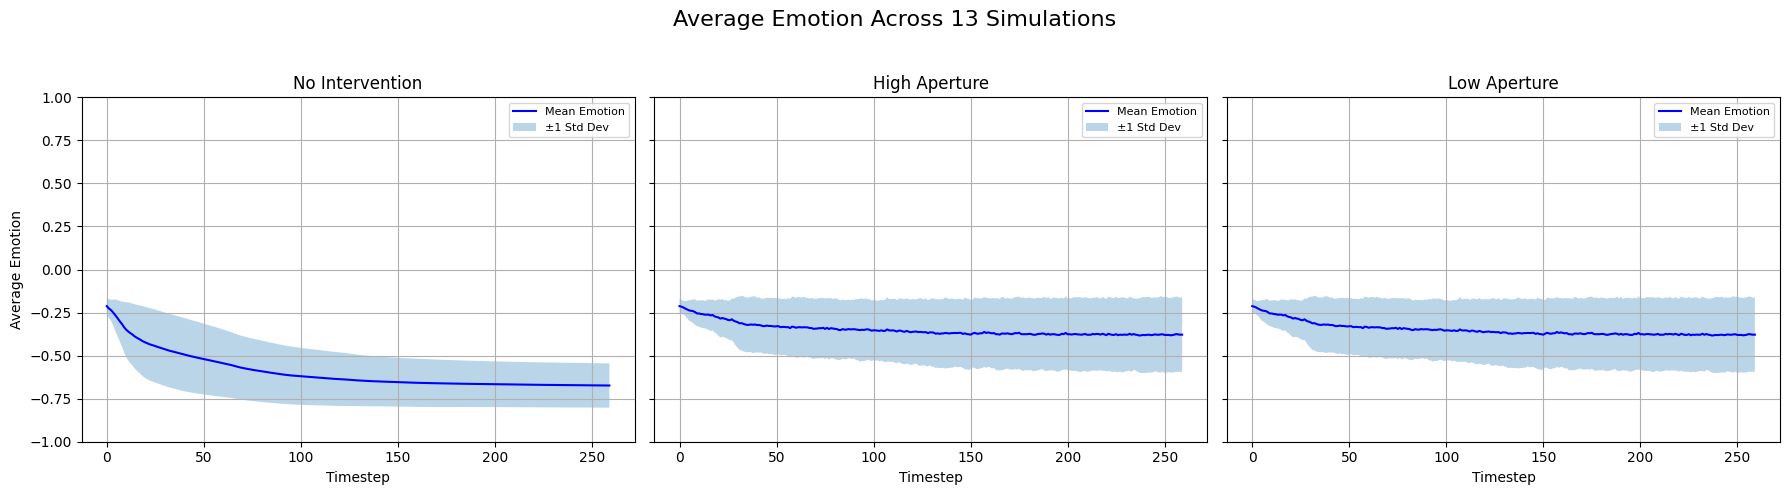

In [ ]:
def plot_avg_emotion_side_by_side(df_list, styles, runs, ylim=(-1, 1), figsize=(18,5)):
    """
    Plot mean emotion per timestep with ±1 standard deviation shading for multiple styles side-by-side.
    
    Parameters:
    - df_list: list of DataFrames [dfWithout, dfHigh, dfLow]
    - styles: list of string labels
    - runs: number of simulations
    - ylim: tuple for y-axis limits
    - figsize: figure size
    """
    n_styles = len(df_list)
    fig, axes = plt.subplots(1, n_styles, figsize=figsize, sharey=True)

    for ax, df, style in zip(axes, df_list, styles):
        mean_emotion = df.iloc[:, 1:].mean(axis=1)
        std_emotion = df.iloc[:, 1:].std(axis=1)

        ax.plot(df.index, mean_emotion, label="Mean Emotion", color='blue')
        ax.fill_between(df.index,
                        mean_emotion - std_emotion,
                        mean_emotion + std_emotion,
                        alpha=0.3, label="±1 Std Dev")
        ax.set_title(style)
        ax.set_xlabel("Timestep")
        ax.grid(True)
        if ax == axes[0]:
            ax.set_ylabel("Average Emotion")
        ax.set_ylim(*ylim)
        ax.legend(loc='upper right', fontsize=8)

    plt.suptitle(f"Average Emotion Across {runs} Simulations", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

plot_avg_emotion_side_by_side([dfWithout, dfHigh, dfLow], styles, runs)

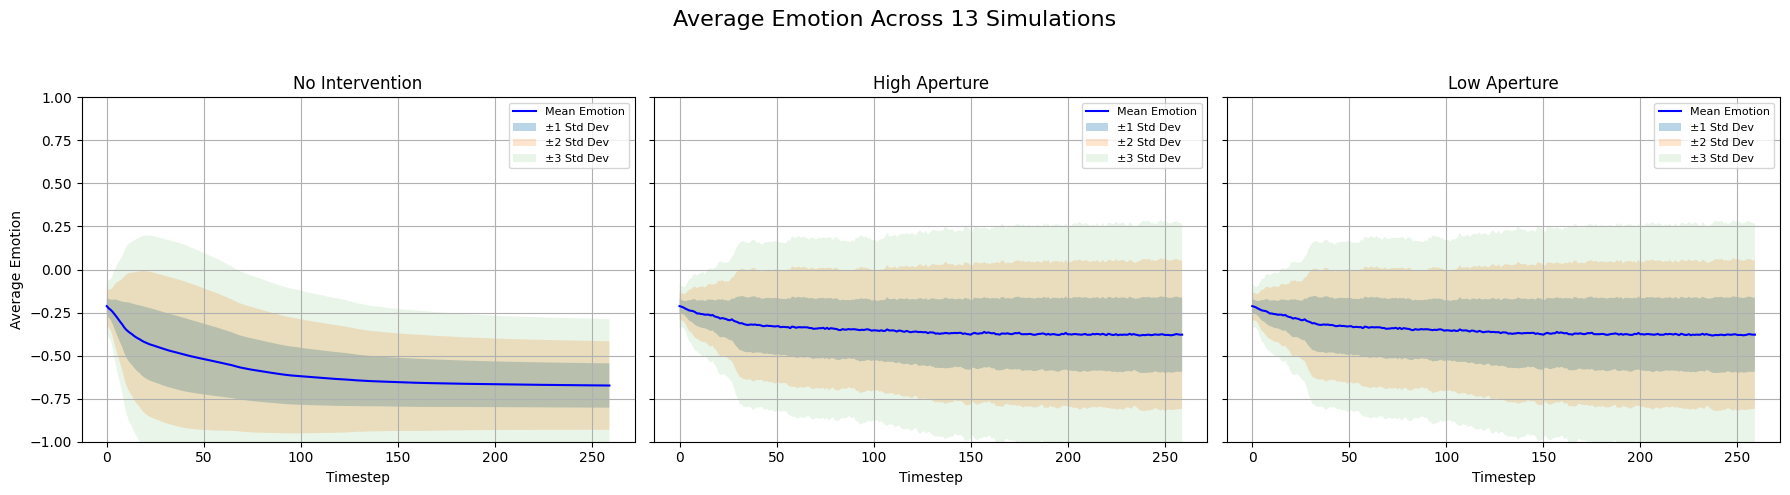

In [ ]:
def plot_all_styles_emotion(df_list, styles, runs, max_std=3):
    """
    Plot average emotion with ±1, ±2, ±3 std deviations for multiple styles in subplots.
    
    df_list : list of DataFrames [dfWithout, dfHigh, dfLow]
    styles : list of strings ["No Intervention", "High Aperture", "Low Aperture"]
    """
    n_styles = len(df_list)
    fig, axes = plt.subplots(1, n_styles, figsize=(18, 5), sharey=True)

    alphas = [0.3, 0.2, 0.1]

    for ax, df, style in zip(axes, df_list, styles):
        mean_emotion = df.iloc[:, 1:].mean(axis=1)
        std_emotion = df.iloc[:, 1:].std(axis=1)

        ax.plot(df.index, mean_emotion, label="Mean Emotion", color='blue')

        for i in range(1, max_std+1):
            ax.fill_between(df.index,
                            mean_emotion - i*std_emotion,
                            mean_emotion + i*std_emotion,
                            alpha=alphas[i-1],
                            label=f"±{i} Std Dev")

        ax.set_title(style)
        ax.set_xlabel("Timestep")
        ax.grid(True)
        if ax == axes[0]:
            ax.set_ylabel("Average Emotion")
        ax.set_ylim(-1, 1)
        ax.legend(loc='upper right', fontsize=8)

    plt.suptitle(f"Average Emotion Across {runs} Simulations", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

plot_all_styles_emotion([dfWithout, dfHigh, dfLow], styles, runs)

In [214]:
# ---------------------------
# Build a tidy dataframe
# ---------------------------
def build_emotion_df(emotion_histories, condition_name):
    """
    Convert emotion_histories (runs × timesteps × agents) into a tidy dataframe:
    Columns: Condition, Timestep, Agent, Emotion
    """
    runs = len(emotion_histories)
    timesteps = len(emotion_histories[0])
    agents = len(emotion_histories[0][0])
    
    data = []
    for run in range(runs):
        for t in range(timesteps):
            for agent in range(agents):
                data.append({
                    "Condition": condition_name,
                    "Timestep": t,
                    "Agent": agent,
                    "Emotion": emotion_histories[run][t][agent]
                })
    return pd.DataFrame(data)

# Create the full dataframe
df_wo = build_emotion_df(all_results_wo.emotion_histories, "No Intervention")
df_H = build_emotion_df(all_results_H.emotion_histories, "High Aperture")
df_L = build_emotion_df(all_results_L.emotion_histories, "Low Aperture")

df = pd.concat([df_wo, df_H, df_L], ignore_index=True)

# ---------------------------
# Statistical functions
# ---------------------------

def ks_test_last_timestep(df):
    last_timestep = df["Timestep"].max()
    groups = df[df["Timestep"] == last_timestep].groupby("Condition")["Emotion"].apply(list)
    conditions = groups.index.tolist()
    
    results = []
    for i in range(len(conditions)):
        for j in range(i+1, len(conditions)):
            stat, p = ks_2samp(groups[conditions[i]], groups[conditions[j]])
            results.append({"Comparison": f"{conditions[i]} vs {conditions[j]}",
                            "KS_stat": stat, "p_value": p})
    return pd.DataFrame(results)

def levene_test_last_timestep(df):
    last_timestep = df["Timestep"].max()
    groups = df[df["Timestep"] == last_timestep].groupby("Condition")["Emotion"].apply(list)
    stat, p = levene(*groups)
    return pd.DataFrame([{"Levene_stat": stat, "p_value": p}])

def compute_auc(df):
    results = []
    for cond, group in df.groupby("Condition"):
        mean_curve = group.groupby("Timestep")["Emotion"].mean().sort_index()
        area = auc(mean_curve.index.values, mean_curve.values)
        results.append({"Condition": cond, "AUC": area})
    return pd.DataFrame(results)

def compute_slopes(df):
    results = []
    for cond, group in df.groupby("Condition"):
        mean_curve = group.groupby("Timestep")["Emotion"].mean().sort_index()
        slope, intercept, r_value, p_value, std_err = linregress(mean_curve.index, mean_curve.values)
        results.append({"Condition": cond, "Slope": slope, "R2": r_value**2, "p_value": p_value})
    return pd.DataFrame(results)

# ---------------------------
# Run all analyses
# ---------------------------

ks_results = ks_test_last_timestep(df)
levene_results = levene_test_last_timestep(df)
auc_results = compute_auc(df)
slope_results = compute_slopes(df)

# ---------------------------
# Pretty print
# ---------------------------

print("KS Test (Final Timestep):")
print(ks_results.to_string(index=False), "\n")

print("Levene’s Test (Final Timestep):")
print(levene_results.to_string(index=False), "\n")

print("Trajectory AUC:")
print(auc_results.to_string(index=False), "\n")

print("Trajectory Slopes:")
print(slope_results.to_string(index=False), "\n")


KS Test (Final Timestep):
                      Comparison  KS_stat      p_value
   High Aperture vs Low Aperture      0.0 1.000000e+00
High Aperture vs No Intervention      0.5 4.832620e-21
 Low Aperture vs No Intervention      0.5 4.832620e-21 

Levene’s Test (Final Timestep):
 Levene_stat  p_value
    5.927905  0.00284 

Trajectory AUC:
      Condition         AUC
  High Aperture  -85.089720
   Low Aperture  -85.089720
No Intervention -154.641317 

Trajectory Slopes:
      Condition     Slope       R2      p_value
  High Aperture -0.000397 0.714085 2.239104e-72
   Low Aperture -0.000397 0.714085 2.239104e-72
No Intervention -0.001160 0.704079 1.939067e-70 



### A Little Fine-Grained Analysis

In [169]:
def compare_leader_styles(df_high, df_low, timestep=-1, bins=10):
    """
    Compare High vs Low leader styles on distribution, variance, and entropy.
    
    Args:
        df_high, df_low: DataFrames of agent emotions (rows = agents, cols = timesteps).
        timestep: which timestep to analyze (-1 = final).
        bins: number of bins for entropy calculation.
    """
    
    # --- Extract data ---
    high_vals = df_high.iloc[:, timestep]
    low_vals = df_low.iloc[:, timestep]
    
    # --- 1. KS test ---
    ks_stat, ks_pval = ks_2samp(high_vals, low_vals)
    
    # --- 2. Variance ---
    var_high = high_vals.var()
    var_low = low_vals.var()
    
    # --- 3. Entropy ---
    def calc_entropy(vals):
        hist, _ = np.histogram(vals, bins=bins, density=True)
        return entropy(hist + 1e-9)  # smooth to avoid log(0)
    
    ent_high = calc_entropy(high_vals)
    ent_low = calc_entropy(low_vals)
    
    # --- Print results ---
    print(f"\nComparison at timestep {timestep}:")
    print(f" KS test: stat={ks_stat:.3f}, p={ks_pval:.4f}")
    print(f" Variance: High={var_high:.3f}, Low={var_low:.3f}")
    print(f" Entropy:  High={ent_high:.3f}, Low={ent_low:.3f}")
    
    return {
        "ks_stat": ks_stat, "ks_pval": ks_pval,
        "var_high": var_high, "var_low": var_low,
        "ent_high": ent_high, "ent_low": ent_low
    }

results = compare_leader_styles(dfHigh, dfLow, timestep=-1)


Comparison at timestep -1:
 KS test: stat=0.000, p=1.0000
 Variance: High=0.019, Low=0.019
 Entropy:  High=2.024, Low=2.024


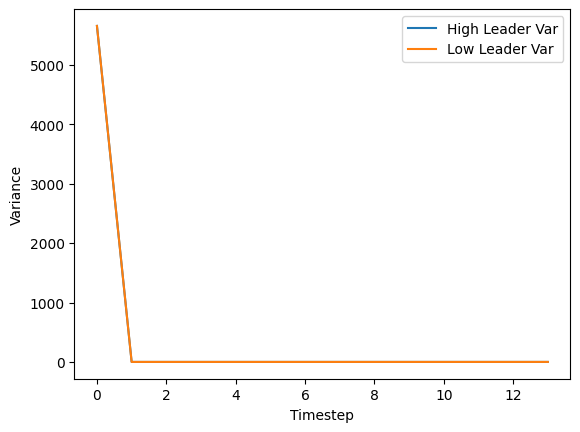

In [170]:
def compare_leader_styles_over_time(df_high, df_low, bins=10):
    """
    Compare High vs Low leader styles over all timesteps.
    
    Args:
        df_high, df_low: DataFrames of agent emotions (rows = agents, cols = timesteps).
        bins: number of bins for entropy calculation.
        
    Returns:
        DataFrame with KS statistic, KS p-value, variance, and entropy across timesteps.
    """
    
    n_steps = df_high.shape[1]
    results = []

    def calc_entropy(vals):
        hist, _ = np.histogram(vals, bins=bins, density=True)
        return entropy(hist + 1e-9)  # smooth to avoid log(0)
    
    for t in range(n_steps):
        high_vals = df_high.iloc[:, t]
        low_vals = df_low.iloc[:, t]
        
        # KS test
        ks_stat, ks_pval = ks_2samp(high_vals, low_vals)
        
        # Variance
        var_high = high_vals.var()
        var_low = low_vals.var()
        
        # Entropy
        ent_high = calc_entropy(high_vals)
        ent_low = calc_entropy(low_vals)
        
        results.append({
            "timestep": t,
            "ks_stat": ks_stat,
            "ks_pval": ks_pval,
            "var_high": var_high,
            "var_low": var_low,
            "ent_high": ent_high,
            "ent_low": ent_low
        })
    
    return pd.DataFrame(results)

results_time = compare_leader_styles_over_time(dfHigh, dfLow)


plt.plot(results_time["timestep"], results_time["var_high"], label="High Leader Var")
plt.plot(results_time["timestep"], results_time["var_low"], label="Low Leader Var")
plt.xlabel("Timestep")
plt.ylabel("Variance")
plt.legend()
plt.show()

Let's increase the granularity and use the raw emotions

In [203]:
print(type(all_results_H.emotion_histories))
print(len(all_results_H.emotion_histories))  # number of simulations
print(type(all_results_H.emotion_histories[0]))
print(len(all_results_H.emotion_histories[0]))  # the number of timesteps
print(len(all_results_H.emotion_histories[0][0])) # the number of agents
print(all_results_H.emotion_histories[0][0][:10]) # this tells you the raw emotion values

<class 'list'>
13
<class 'list'>
261
14
[-0.2714444712382954, -0.29048619504672146, -0.3413981991755356, -0.008756812126159308, -0.277873902388187, -0.44132255861355024, -0.011177996954343516, -0.027115312283609805, -0.3085863442652802, -0.0037819935224410184]


No Intervention vs High Aperture: stat=0.403, p=0.000
No Intervention vs Low Aperture: stat=0.403, p=0.000
High Aperture vs Low Aperture: stat=0.000, p=1.000


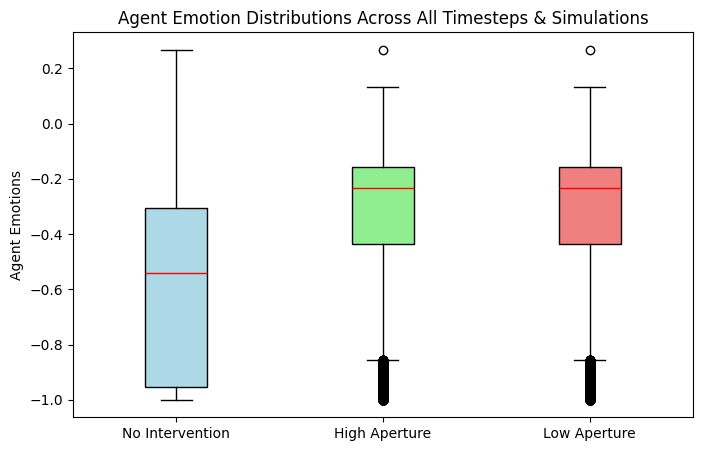

In [211]:
def flatten_emotions(emotion_histories):
    """
    Convert emotion_histories (list of simulations × timesteps × agents)
    into a 1D NumPy array of all agent emotions across all timesteps and simulations.
    """
    arr = np.array(emotion_histories)  # shape: (runs, timesteps, agents)
    return arr.flatten()


def flatten_emotions_all(styles_histories):
    """
    Flatten all agent-timestep emotions for multiple styles.
    Input: list of emotion_histories for each style.
    Output: list of 1D arrays per style.
    """
    return [flatten_emotions(hist) for hist in styles_histories]

def compare_all_styles(styles_histories, styles, test='ks'):
    """
    Perform pairwise statistical tests between all styles.
    Returns a dictionary of results.
    """
    flattened = flatten_emotions_all(styles_histories)
    n = len(flattened)
    results = {}
    
    for i in range(n):
        for j in range(i+1, n):
            if test == 'ks':
                stat, p = ks_2samp(flattened[i].flatten(), flattened[j].flatten())
            elif test == 'mw':
                stat, p = mannwhitneyu(flattened[i].flatten(), flattened[j].flatten(), alternative='two-sided')
            results[f"{styles[i]} vs {styles[j]}"] = (stat, p)
    return results

def plot_all_styles_distributions(styles_histories, styles, colors=None):
    """
    Side-by-side boxplots for multiple styles with custom colors and clean layout.
    
    Parameters:
    - styles_histories: list of emotion_histories (runs × timesteps × agents)
    - styles: list of style names
    - colors: list of colors to use for each style (optional)
    """
    flattened = [hist.flatten() for hist in flatten_emotions_all(styles_histories)]
    
    if colors is None:
        colors = ['lightblue', 'lightgreen', 'lightcoral'][:len(styles)]
    
    plt.figure(figsize=(8,5))
    box = plt.boxplot(flattened, tick_labels=styles, patch_artist=True,
                      medianprops=dict(color='red'),
                      whiskerprops=dict(color='black'),
                      capprops=dict(color='black'))
    
    # Set custom box colors
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
    
    plt.ylabel("Agent Emotions")
    plt.title("Agent Emotion Distributions Across All Timesteps & Simulations")
    plt.grid(False)  # remove background grid
    plt.show()



styles_histories = [
    all_results_wo.emotion_histories,
    all_results_H.emotion_histories,
    all_results_L.emotion_histories
]

styles = ['No Intervention', 'High Aperture', 'Low Aperture']

# Pairwise comparisons
results = compare_all_styles(styles_histories, styles)
for k, v in results.items():
    print(f"{k}: stat={v[0]:.3f}, p={v[1]:.3f}")

# Boxplot
plot_all_styles_distributions(styles_histories, styles)

## Structure Time!

We've got two lists of graphs, so keep in mind that the analysis we do might have to be done over all of them

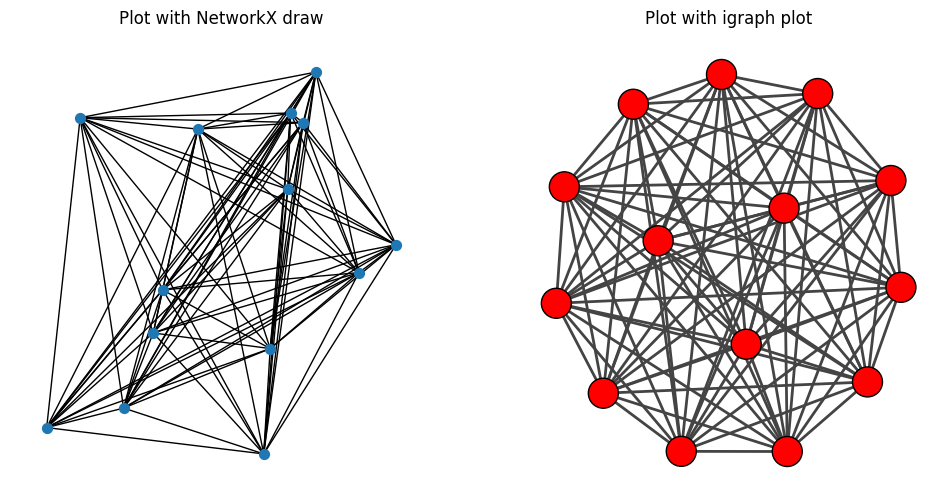

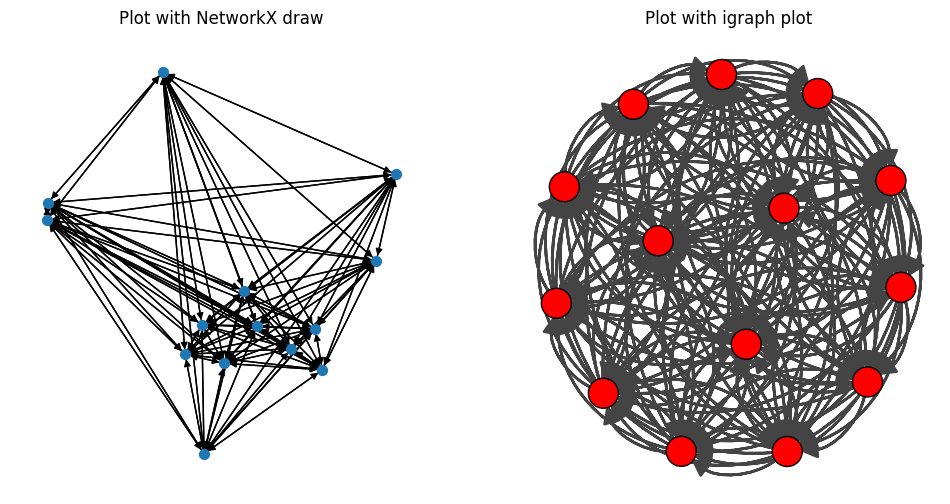

In [177]:
# sample visual
import igraph as ig
networkG = all_results_H.G_networks
networkDG = all_results_H.DG_networks

# convert to igraph
h = ig.Graph.from_networkx(networkG[2])  # using the third run's network for plotting

# Plot the same network with NetworkX and igraph
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# NetworkX draw
ax0.set_title("Plot with NetworkX draw")
nx.draw_kamada_kawai(networkG[2], node_size=50, ax=ax0)

# igraph draw
ax1.set_title("Plot with igraph plot")
layout = h.layout_kamada_kawai()
ig.plot(h, layout=layout, target=ax1)
plt.axis("off")
plt.show()


f = ig.Graph.from_networkx(networkDG[2])  # using the third run's network for plotting

# Plot the same network with NetworkX and igraph
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# NetworkX draw
ax0.set_title("Plot with NetworkX draw")
nx.draw_kamada_kawai(networkDG[2], node_size=50, ax=ax0)

# igraph draw
ax1.set_title("Plot with igraph plot")
layout = f.layout_kamada_kawai()
ig.plot(f, layout=layout, target=ax1)
plt.axis("off")
plt.show()

Focus on edge weights and tools using edge weights

Possible hypotheses:
- Does network structure affect intervention influence?  
***Since only one structure has been used as of yet, bipartite community, this question should be revised if it's to be used in the current paper unless another structure is tested. Alternatively, we could compare tight-bipartite and loose-bipartite (referring to the intra and inter strengths used for the intimacy matrix generation) since that would be quickest to test and compare.***

- Compare starting network and ending network

In [178]:
# I don't like these variable names, but lets just continue
Gs_wo = all_results_wo.G_networks  # list of undirected newtworkx graphs, one per run (interaction frequencies)
Gs_H = all_results_H.G_networks
Gs_L = all_results_L.G_networks
Gs_styles = [Gs_wo, Gs_H, Gs_L]  # for iterating through each style when doing analysis -- list of lists

DGs_wo = all_results_wo.DG_networks  # list of directed newtworkx graphs, one per run (emotion absorption)
DGs_H = all_results_H.DG_networks
DGs_L = all_results_L.DG_networks
DGs_styles = [DGs_wo, DGs_H, DGs_L]

I_wo = all_results_wo.intimacy_matrices  # list of intimacy matrices, one per run
I_H = all_results_H.intimacy_matrices
I_L = all_results_L.intimacy_matrices
I_styles = [I_wo, I_H, I_L]

### Frobenius norm! 
We'll use this to compare simulations within a style to each other to get an idea of how much they vary from each other

In [179]:
# Step 1) Convert each network to its adjacency matrix
def graph_to_adj_matrix(graphs_list):
    '''
    Convert a list of NetworkX graphs to their adjacency matrices.
    '''
    adj_matrices = []
    for G in graphs_list:
        A = nx.to_numpy_array(G, weight='weight', dtype=float)  # REMEMBER: for the DG graphs, A_ij = how much i influenced j (so instead of thinking 'how much did j get from i?', think 'how much did i give to j?')
        adj_matrices.append(A)

    return adj_matrices

# for each style of G and DG, apply the function
Gs_wo_adj = graph_to_adj_matrix(Gs_wo)  # list of adjacency matrices, one per run
Gs_H_adj = graph_to_adj_matrix(Gs_H)
Gs_L_adj = graph_to_adj_matrix(Gs_L)
Gs_styles_adj = [Gs_wo_adj, Gs_H_adj, Gs_L_adj]  # list of lists of adjacency matrices

DGs_wo_adj = graph_to_adj_matrix(DGs_wo)
DGs_H_adj = graph_to_adj_matrix(DGs_H)
DGs_L_adj = graph_to_adj_matrix(DGs_L)
DGs_styles_adj = [DGs_wo_adj, DGs_H_adj, DGs_L_adj]

In [180]:
# Step 2) Compute Frobenius norms between each pair of adjacency matrices within a style
def frobenius_norms_comparison(adj_list):
    '''
    We want to compare the adjacency matrices within a style to the mean matrix of that style to get an idea of how much they vary from each other, so we compute the Frobenius norm between each adjacency matrix and the mean matrix. 
    Smaller = more similar
    '''
    mean_matrix = np.mean(adj_list, axis=0)
    frobenius_norms = np.array([np.linalg.norm(A - mean_matrix, 'fro') for A in adj_list])
    return mean_matrix, frobenius_norms

# F norms for G and DG
mean_matrix_G_wo, fnorm_Gs_wo = frobenius_norms_comparison(Gs_wo_adj)
mean_matrix_G_H, fnorm_Gs_H = frobenius_norms_comparison(Gs_H_adj)
mean_matrix_G_L, fnorm_Gs_L = frobenius_norms_comparison(Gs_L_adj)

mean_matrix_DG_wo, fnorm_DGs_wo = frobenius_norms_comparison(DGs_wo_adj)
mean_matrix_DG_H, fnorm_DGs_H = frobenius_norms_comparison(DGs_H_adj)
mean_matrix_DG_L, fnorm_DGs_L = frobenius_norms_comparison(DGs_L_adj)

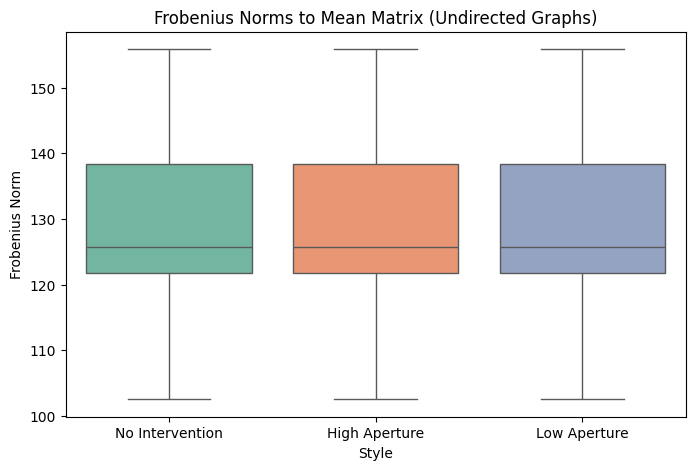

In [181]:
# Step 3) Visualize the Frobenius norms
styles = ['No Intervention', 'High Aperture', 'Low Aperture']
fnorm_data = {
    'style': [],
    'frobenius_norm': []
}

# Undirected graphs
for style_name, fnorms in zip(styles, [fnorm_Gs_wo, fnorm_Gs_H, fnorm_Gs_L]):
    fnorm_data['style'].extend([style_name]*len(fnorms))
    fnorm_data['frobenius_norm'].extend(fnorms)


df_fnorm = pd.DataFrame(fnorm_data)


plt.figure(figsize=(8,5))
sns.boxplot(x='style', y='frobenius_norm', data=df_fnorm, palette='Set2', hue='style', legend=False)
plt.title("Frobenius Norms to Mean Matrix (Undirected Graphs)")
plt.ylabel("Frobenius Norm")
plt.xlabel("Style")
plt.show()


The above looking identical to each other makes sense because these graphs represent the interaction frequency, so style shouldn't affect this much at all. There seems to be just one simulation which had a different enough amount of interactions amongst agents

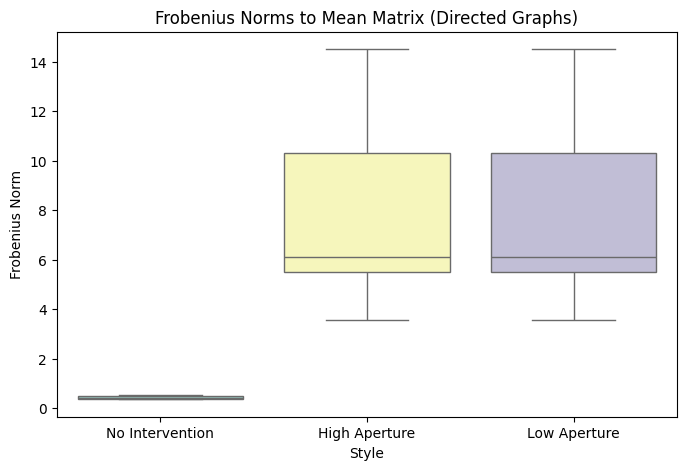

In [182]:
# Directed graphs
fnorm_data_dir = {'style': [], 'frobenius_norm': []}
for style_name, fnorms in zip(styles, [fnorm_DGs_wo, fnorm_DGs_H, fnorm_DGs_L]):
    fnorm_data_dir['style'].extend([style_name]*len(fnorms))
    fnorm_data_dir['frobenius_norm'].extend(fnorms)

df_fnorm_dir = pd.DataFrame(fnorm_data_dir)

plt.figure(figsize=(8,5))
sns.boxplot(x='style', y='frobenius_norm', data=df_fnorm_dir, palette='Set3', hue='style', legend=False)
plt.title("Frobenius Norms to Mean Matrix (Directed Graphs)")
plt.ylabel("Frobenius Norm")
plt.xlabel("Style")
plt.show()


For the directed graphs, there are no far outliers either, but we do see that just the act of leader intervention seems to have some sort of an affect on the emotion absorption of agents such that it introduces **a lot** more variabilty in that regard. That's interesting...

Overall, while there is variety amongst the 14 simulations, most are close enough to the mean, with the exception of one outlier for the G graphs for all three styles. So, we can proceed with a coarse-grained analysis using the mean matrices for each style, and just look at that one outlier separately or exclude it entirely or just from any interaction-related analysis.

In [183]:
# Function to find outlier index
def find_outlier(fnorms):
    """
    Returns the index of the simulation with the largest Frobenius norm
    relative to the style mean.
    """
    return np.argmax(fnorms)

# Undirected G graphs
outlier_idx_wo = find_outlier(fnorm_Gs_wo)
outlier_idx_H = find_outlier(fnorm_Gs_H)
outlier_idx_L = find_outlier(fnorm_Gs_L)

print("Outlier simulation indices for G graphs:")
print(f"No Intervention: {outlier_idx_wo}")
print(f"High Aperture: {outlier_idx_H}")
print(f"Low Aperture: {outlier_idx_L}")

Outlier simulation indices for G graphs:
No Intervention: 5
High Aperture: 5
Low Aperture: 5


In [184]:
# Let's remove 5 from everything just since i'm not sure what possible effect it might have on the analysis
outlier_idx = 5
def remove_index(lst, idx):
    return [item for i, item in enumerate(lst) if i != idx]

Gs_wo_adj = remove_index(Gs_wo_adj, outlier_idx)
Gs_H_adj  = remove_index(Gs_H_adj, outlier_idx)
Gs_L_adj  = remove_index(Gs_L_adj, outlier_idx)

DGs_wo_adj = remove_index(DGs_wo_adj, outlier_idx)
DGs_H_adj  = remove_index(DGs_H_adj, outlier_idx)
DGs_L_adj  = remove_index(DGs_L_adj, outlier_idx)

I_wo = remove_index(I_wo, outlier_idx)
I_H  = remove_index(I_H, outlier_idx)
I_L  = remove_index(I_L, outlier_idx)

## There is no re-indexing done, so just remember that everything goes 0,1,2,3,4,6,...,13 skipping 5


### Coarse-grained Analysis
We're using the mean matrices for the G-interaction and DG-absorption graphs. We can do a fine-grained analysis to focus more on the initial conditions of agent parameters, but for now our focus is on **leader intervention** and network structure (which we deliberately created)

In [185]:
# Are the mean matrices for the G and DG graphs the same for High and Low Aperture?
print(f"G's identical: {np.array_equal(mean_matrix_G_H, mean_matrix_G_L)}")
print(f"DG's identical: {np.array_equal(mean_matrix_DG_H, mean_matrix_DG_L)}")


G's identical: True
DG's identical: True


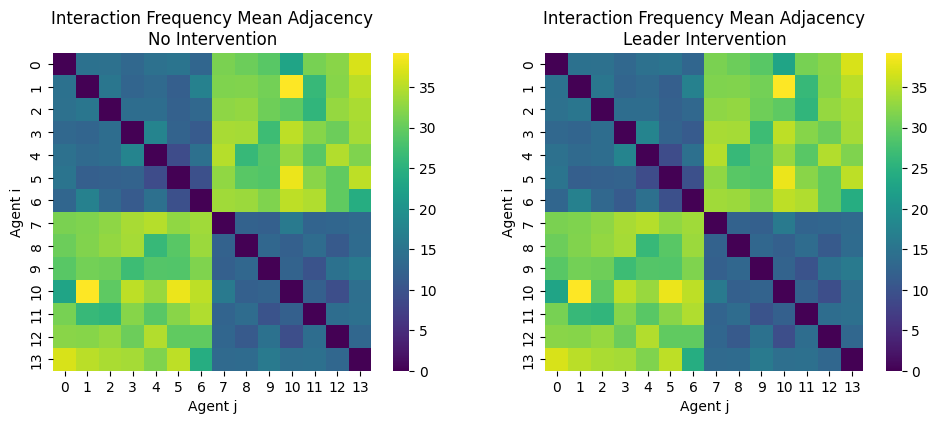

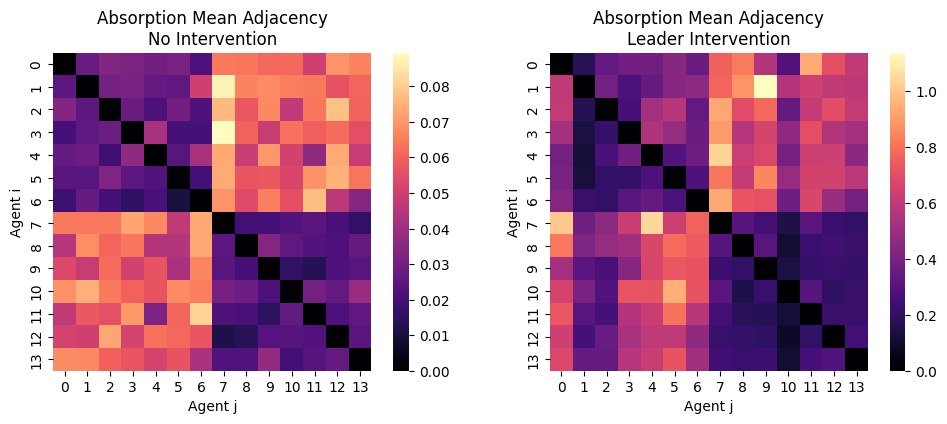

In [186]:
# Heatmaps to visualize the mean adjacency matrices for G and DG graphs
# Mean matrices you computed earlier
styles = ['No Intervention', 'Leader Intervention']  # using general intervention since they are identical
mean_matrix_G_HL = mean_matrix_G_H
mean_matrix_DG_HL = mean_matrix_DG_H

mean_matrices_G = [mean_matrix_G_wo, mean_matrix_G_HL]
mean_matrices_DG = [mean_matrix_DG_wo, mean_matrix_DG_HL]

# Plot G graphs (interaction frequencies)
plt.figure(figsize=(15,4))
for i, (style, mat) in enumerate(zip(styles, mean_matrices_G)):
    plt.subplot(1, 3, i+1)
    sns.heatmap(mat, cmap='viridis', square=True)
    plt.title(f'Interaction Frequency Mean Adjacency\n{style}')
    plt.xlabel('Agent j')
    plt.ylabel('Agent i')
plt.tight_layout()
plt.show()

# Plot DG graphs (emotion absorption)
plt.figure(figsize=(15,4))
for i, (style, mat) in enumerate(zip(styles, mean_matrices_DG)):
    plt.subplot(1, 3, i+1)
    sns.heatmap(mat, cmap='magma', square=True)
    plt.title(f'Absorption Mean Adjacency\n{style}')
    plt.xlabel('Agent j')
    plt.ylabel('Agent i')
plt.tight_layout()
plt.show()


In [187]:
# Clustering coefficient for community detection verification
def weighted_clustering_coefficient(adj_matrix, directed=False):
    """
    Compute the average weighted clustering coefficient for a graph represented by an adjacency matrix.

    Parameters:
    - adj_matrix: np.ndarray, adjacency matrix with weights
    - directed: bool, whether the graph is directed (will convert to undirected for clustering if True)

    Returns:
    - avg_clustering: float, average weighted clustering coefficient
    """
    if directed:
        # Convert directed to undirected for clustering purposes
        G = nx.from_numpy_array(adj_matrix, create_using=nx.DiGraph)
        G_undirected = G.to_undirected()
    else:
        G_undirected = nx.from_numpy_array(adj_matrix)

    # Compute weighted clustering coefficient per node
    clustering_dict = nx.clustering(G_undirected, weight='weight')
    avg_clustering = np.mean(list(clustering_dict.values()))
    return avg_clustering


# Undirected graphs (interaction frequency)
avg_clust_G_wo = weighted_clustering_coefficient(mean_matrix_G_wo, directed=False)
avg_clust_G_HL  = weighted_clustering_coefficient(mean_matrix_G_HL, directed=False)

# Directed graphs (emotion absorption)
avg_clust_DG_wo = weighted_clustering_coefficient(mean_matrix_DG_wo, directed=True)
avg_clust_DG_HL  = weighted_clustering_coefficient(mean_matrix_DG_HL, directed=True)

print("                             No Intervention  Leader Intervention")
print("Weighted clustering (G)  :", avg_clust_G_wo,  avg_clust_G_HL)
print("Weighted clustering (DG) :", avg_clust_DG_wo, avg_clust_DG_HL)


                             No Intervention  Leader Intervention
Weighted clustering (G)  : 0.5488805527108175 0.5488805527108175
Weighted clustering (DG) : 0.4820112563598619 0.37415989391345145


Intervention has no affect on the interaction patterns amongst agents (as we saw in the first box-whisker plot).

Intervention has some affect when it comes to the dynamics of emotional absorption though, so there is some interference there. This suggests that intervention interrupts (local patterns of?) emotional influence among agents! something something "the propagation of emotions"

In [188]:
# Centrality measures to identify key agents
def compute_centrality_measures(G_mean, DG_mean):
    """
    Compute weighted closeness and betweenness centrality for both G (undirected) and DG (directed) mean matrices.
    Returns the mean centrality values per style.
    """
    # Convert numpy adjacency matrices back to NetworkX graphs
    G_graph = nx.from_numpy_array(G_mean, create_using=nx.Graph())
    DG_graph = nx.from_numpy_array(DG_mean, create_using=nx.DiGraph())

    # Weighted closeness centrality
    closeness_G = nx.closeness_centrality(G_graph, distance='weight')
    closeness_DG = nx.closeness_centrality(DG_graph, distance='weight')

    # Weighted betweenness centrality
    betweenness_G = nx.betweenness_centrality(G_graph, weight='weight', normalized=True)
    betweenness_DG = nx.betweenness_centrality(DG_graph, weight='weight', normalized=True)

    # Mean values across all nodes
    mean_values = {
        'closeness_G': np.mean(list(closeness_G.values())),
        'closeness_DG': np.mean(list(closeness_DG.values())),
        'betweenness_G': np.mean(list(betweenness_G.values())),
        'betweenness_DG': np.mean(list(betweenness_DG.values()))
    }
    return mean_values

centrality_no_intervention = compute_centrality_measures(mean_matrix_G_wo, mean_matrix_DG_wo)
centrality_leader_intervention = compute_centrality_measures(mean_matrix_G_H, mean_matrix_DG_H)

# For pretty printing
centrality_df = pd.DataFrame({
    'No Intervention': centrality_no_intervention,
    'Leader Intervention': centrality_leader_intervention
}).T  # transpose so styles are rows
centrality_df = centrality_df.round(4)  # rounding for readability

print(centrality_df)


                     closeness_G  closeness_DG  betweenness_G  betweenness_DG
No Intervention           0.0433       23.5937         0.0037          0.0183
Leader Intervention       0.0433        2.4734         0.0037          0.0192


In [ ]:
def compute_per_agent_centralities(adj_list, directed=False):
    """
    Compute closeness and betweenness centralities for each agent in each simulation.
    Returns a list of dicts (one per simulation) for closeness and betweenness.
    """
    all_closeness = []
    all_betweenness = []
    
    for A in adj_list:
        if directed:
            G = nx.from_numpy_array(A, create_using=nx.DiGraph)
        else:
            G = nx.from_numpy_array(A)
        
        closeness = nx.closeness_centrality(G, distance='weight')
        betweenness = nx.betweenness_centrality(G, weight='weight')
        all_closeness.append(closeness)
        all_betweenness.append(betweenness)
    
    return all_closeness, all_betweenness

def per_agent_centrality_summary(adj_styles, styles, directed=False):
    """
    Computes per-agent centralities for multiple styles.
    Returns a dict of DataFrames: keys are style names, values are DataFrames with agents as columns,
    simulations as rows.
    """
    summary = {}
    for adj_list, style in zip(adj_styles, styles):
        closeness_list, betweenness_list = compute_per_agent_centralities(adj_list, directed=directed)
        df_closeness = pd.DataFrame(closeness_list)
        df_betweenness = pd.DataFrame(betweenness_list)
        summary[style] = {'closeness': df_closeness, 'betweenness': df_betweenness}
    return summary

G_styles = [Gs_wo_adj, Gs_H_adj]  # since H and L are identical, just pick one for intervention
G_centrality_summary = per_agent_centrality_summary(G_styles, styles, directed=False)

DG_styles = [DGs_wo_adj, DGs_H_adj]
DG_centrality_summary = per_agent_centrality_summary(DG_styles, styles, directed=True)

def agent_centrality_overview(summary_dict):
    """
    Compute per-agent mean and std for closeness and betweenness across simulations.
    Identify top agents (highest centrality) for focus.
    """
    for style, metrics in summary_dict.items():
        print(f"\n=== {style} ===")
        
        # Compute mean and std across simulations
        mean_closeness = metrics['closeness'].mean()
        std_closeness = metrics['closeness'].std()
        mean_betweenness = metrics['betweenness'].mean()
        std_betweenness = metrics['betweenness'].std()
        
        overview_df = pd.DataFrame({
            'Closeness_mean': mean_closeness.round(4),
            'Closeness_std': std_closeness.round(4),
            'Betweenness_mean': mean_betweenness.round(4),
            'Betweenness_std': std_betweenness.round(4)
        })
        
        print("Per-agent summary (mean ± std):")
        print(overview_df)
        
        # Highlight top 2 agents by mean closeness and betweenness
        top_closeness = overview_df['Closeness_mean'].nlargest(2)
        top_betweenness = overview_df['Betweenness_mean'].nlargest(2)
        
        print("\nAgents to focus on:")
        print("Top closeness:", list(top_closeness.index))
        print("Top betweenness:", list(top_betweenness.index))

print("Undirected Graphs (Interaction frequency):")
agent_centrality_overview(G_centrality_summary)

print("\nDirected Graphs (Emotion absorption):")
agent_centrality_overview(DG_centrality_summary)

Undirected Graphs (Interaction frequency):

=== No Intervention ===
Per-agent summary (mean ± std):
    Closeness_mean  Closeness_std  Betweenness_mean  Betweenness_std
0           0.0706         0.0132            0.0719           0.0873
1           0.0640         0.0141            0.0588           0.1016
2           0.0699         0.0163            0.0817           0.1106
3           0.0695         0.0146            0.0686           0.0749
4           0.0658         0.0095            0.0370           0.0468
5           0.0790         0.0197            0.1754           0.1668
6           0.0714         0.0161            0.1079           0.1355
7           0.0681         0.0155            0.0347           0.0399
8           0.0696         0.0125            0.0725           0.0887
9           0.0736         0.0161            0.0915           0.1637
10          0.0659         0.0106            0.0431           0.0731
11          0.0733         0.0190            0.1293           0.1573
12 

We can interpret that later

In [190]:
# Undirected (weighted degree assortativity)
assort_G_wo = nx.degree_pearson_correlation_coefficient(
    nx.from_numpy_array(mean_matrix_G_wo), weight='weight')
assort_G_H = nx.degree_pearson_correlation_coefficient(
    nx.from_numpy_array(mean_matrix_G_H), weight='weight')

# Directed (weighted degree assortativity)
assort_DG_wo = nx.degree_pearson_correlation_coefficient(
    nx.from_numpy_array(mean_matrix_DG_wo, create_using=nx.DiGraph), weight='weight')
assort_DG_H = nx.degree_pearson_correlation_coefficient(
    nx.from_numpy_array(mean_matrix_DG_H, create_using=nx.DiGraph), weight='weight')

assortativity_results = {
    'Graph Type': ['Undirected (G)', 'Undirected (G)', 'Directed (DG)', 'Directed (DG)'],
    'Style': ['No Intervention', 'Leader Intervention', 'No Intervention', 'Leader Intervention'],
    'Weighted Degree Pearson r': [
        assort_G_wo, assort_G_H,
        assort_DG_wo, assort_DG_H
    ]
}

df_assortativity = pd.DataFrame(assortativity_results)
print(df_assortativity.round(4))

       Graph Type                Style  Weighted Degree Pearson r
0  Undirected (G)      No Intervention                    -0.0769
1  Undirected (G)  Leader Intervention                    -0.0769
2   Directed (DG)      No Intervention                     0.0172
3   Directed (DG)  Leader Intervention                     0.0167


In [191]:
from itertools import combinations

def count_motifs(G, motif_size, directed=False):
    """
    Counts all unique motifs of a given size in a graph.
    
    Parameters:
        G : NetworkX graph (directed or undirected)
        motif_size : int, number of nodes in the motif
        directed : bool, True if graph is directed
    
    Returns:
        motif_counts : dict, keys are motif adjacency tuples, values are counts
    """
    motif_counts = {}
    nodes = list(G.nodes())
    
    for node_combo in combinations(nodes, motif_size):
        subgraph = G.subgraph(node_combo)
        # adjacency tuple to make it hashable
        adj_tuple = tuple(nx.to_numpy_array(subgraph, dtype=int).flatten())
        motif_counts[adj_tuple] = motif_counts.get(adj_tuple, 0) + 1
    
    return motif_counts

G_mean = nx.from_numpy_array(mean_matrix_G_wo)
motifs_G = count_motifs(G_mean, motif_size=3, directed=False)
DG_mean = nx.from_numpy_array(mean_matrix_DG_H, create_using=nx.DiGraph)
motifs_DG = count_motifs(DG_mean, motif_size=3, directed=True)


def motifs_to_df(motif_counts):
    """
    Convert motif count dictionary to a pretty DataFrame sorted by count.
    """
    df = pd.DataFrame([
        {'motif': k, 'count': v} for k, v in motif_counts.items()
    ])
    df = df.sort_values(by='count', ascending=False).reset_index(drop=True)
    return df

# Undirected graph motifs
df_motifs_G = motifs_to_df(motifs_G)
print("=== Undirected Graph Motifs ===")
print(df_motifs_G.head(10))  # show top 10

# Directed graph motifs
df_motifs_DG = motifs_to_df(motifs_DG)
print("\n=== Directed Graph Motifs ===")
print(df_motifs_DG.head(10))  # show top 10


=== Undirected Graph Motifs ===
                               motif  count
0  (0, 13, 32, 13, 0, 34, 32, 34, 0)      3
1  (0, 13, 12, 13, 0, 12, 12, 12, 0)      3
2  (0, 15, 31, 15, 0, 32, 31, 32, 0)      2
3  (0, 13, 12, 13, 0, 11, 12, 11, 0)      2
4  (0, 13, 31, 13, 0, 34, 31, 34, 0)      2
5  (0, 13, 13, 13, 0, 14, 13, 14, 0)      2
6  (0, 30, 31, 30, 0, 13, 31, 13, 0)      2
7  (0, 13, 33, 13, 0, 34, 33, 34, 0)      2
8  (0, 14, 16, 14, 0, 13, 16, 13, 0)      2
9  (0, 13, 32, 13, 0, 30, 32, 30, 0)      2

=== Directed Graph Motifs ===
                         motif  count
0  (0, 0, 0, 0, 0, 0, 0, 0, 0)    329
1  (0, 0, 0, 0, 0, 0, 1, 0, 0)     11
2  (0, 0, 1, 0, 0, 0, 0, 0, 0)      9
3  (0, 0, 0, 0, 0, 1, 0, 1, 0)      7
4  (0, 0, 1, 0, 0, 0, 1, 0, 0)      4
5  (0, 0, 0, 0, 0, 1, 0, 0, 0)      2
6  (0, 0, 0, 0, 0, 1, 1, 1, 0)      1
7  (0, 1, 0, 0, 0, 0, 0, 0, 0)      1


In [192]:
# -----------------------------
# 1. Weighted Degree / Strength
# -----------------------------
def compute_weighted_strength(graphs, directed=False):
    results = []
    for G in graphs:
        if directed:
            # DG_graphs should be passed here instead of G_graphs
            df = pd.DataFrame({
                'in_strength': dict(G.in_degree(weight='weight')).values(),
                'out_strength': dict(G.out_degree(weight='weight')).values()
            }, index=G.nodes)
        else:
            df = pd.DataFrame({
                'strength': dict(G.degree(weight='weight')).values()
            }, index=G.nodes)
        results.append(df)
    return results

# -----------------------------
# 2. Weighted Clustering
# -----------------------------
def compute_weighted_clustering(graphs):
    """
    Returns a list of Series with weighted clustering coefficient per node.
    Works for both directed and undirected graphs.
    """
    clustering_list = []
    for G in graphs:
        clustering_list.append(nx.clustering(G, weight='weight'))
    return clustering_list

# -----------------------------
# 3. Weighted Centrality
# -----------------------------
def compute_weighted_centrality(graphs, directed=True):
    """
    Returns dictionaries with closeness and betweenness centrality for each graph.
    """
    results_list = []
    for G in graphs:
        # For closeness, define distance as 1/weight so stronger intimacy = shorter distance
        length_dict = {}
        for u, v, d in G.edges(data=True):
            # avoid divide by zero
            d['distance'] = 1.0 / max(d.get('weight', 1e-6), 1e-6)
        closeness = nx.closeness_centrality(G, distance='distance')
        betweenness = nx.betweenness_centrality(G, weight='weight')
        results_list.append({'closeness': closeness, 'betweenness': betweenness})
    return results_list

# -----------------------------
# 4. Weighted Assortativity
# -----------------------------
def compute_weighted_assortativity(graphs):
    """
    Returns a list of weighted assortativity coefficients (degree-based).
    """
    assortativity_list = []
    for G in graphs:
        assortativity_list.append(nx.degree_pearson_correlation_coefficient(G, weight='weight'))
    return assortativity_list

# -----------------------------
# 5. Weighted Motif/Triad Analysis
# -----------------------------
def compute_weighted_triangles(graphs):
    """
    Returns a list with number of triangles weighted by edge weights for each node.
    """
    triangles_list = []
    for G in graphs:
        triangles_list.append(nx.triangles(G))  # Note: triadic counts ignore weights; for weighted, could use sum of weights in triads
    return triangles_list

# -----------------------------
# 6. Summary: visualize edge weights
# -----------------------------
def summarize_edge_weights(graphs):
    """
    Returns a DataFrame summarizing min, max, mean, std of edge weights per graph.
    """
    summary_list = []
    for i, G in enumerate(graphs):
        weights = [d['weight'] for u, v, d in G.edges(data=True)]
        df = pd.DataFrame({
            'graph_id': [i],
            'min_weight': [min(weights)],
            'max_weight': [max(weights)],
            'mean_weight': [sum(weights)/len(weights)],
            'std_weight': [pd.Series(weights).std()]
        })
        summary_list.append(df)
    return pd.concat(summary_list, ignore_index=True)


In [193]:
def full_network_analysis(batch_dict):
    """
    batch_dict: dictionary of the form
        {
            'wo': all_results_wo,
            'H': all_results_H,
            'L': all_results_L
        }
    Each value should have G_networks and DG_networks lists.
    
    Returns:
        analysis_results: nested dictionary with each measure per batch
    """
    analysis_results = {}

    for label, results in batch_dict.items():
        analysis_results[label] = {}

        G_graphs = results.G_networks
        DG_graphs = results.DG_networks

        # Weighted Strength
        analysis_results[label]['weighted_strength'] = compute_weighted_strength(G_graphs, directed=False)
        analysis_results[label]['weighted_strength_directed'] = compute_weighted_strength(DG_graphs, directed=True)


        # Weighted Clustering
        analysis_results[label]['weighted_clustering'] = compute_weighted_clustering(G_graphs)

        # Weighted Centrality
        analysis_results[label]['weighted_centrality'] = compute_weighted_centrality(DG_graphs, directed=True)

        # Weighted Assortativity
        analysis_results[label]['weighted_assortativity'] = compute_weighted_assortativity(G_graphs)

        # Weighted Triangles
        analysis_results[label]['weighted_triangles'] = compute_weighted_triangles(G_graphs)

        # Edge Weight Summary
        analysis_results[label]['edge_weight_summary'] = summarize_edge_weights(G_graphs)

    return analysis_results


In [194]:
batches = {
    'wo': all_results_wo,
    'H': all_results_H,
    'L': all_results_L
}

analysis_results = full_network_analysis(batches)

In [195]:
for label, results in analysis_results.items():
    print(f"\nBatch: {label}")
    print(results['edge_weight_summary'])



Batch: wo
    graph_id  min_weight  max_weight  mean_weight  std_weight
0          0           1          54    22.956044   13.018715
1          1           1          54    22.967033   13.806158
2          2           1          63    23.747253   14.888917
3          3           2          57    23.516484   12.463603
4          4           1          55    23.692308   12.361852
5          5           3          63    23.549451   14.178437
6          6           3          61    23.351648   13.213103
7          7           2          52    22.164835   11.214340
8          8           1          60    23.846154   14.812850
9          9           2          73    23.120879   13.123207
10        10           2          62    22.142857   13.867285
11        11           1          72    23.043956   14.770024
12        12           1          65    22.923077   14.262796

Batch: H
    graph_id  min_weight  max_weight  mean_weight  std_weight
0          0           1          54    22.956044

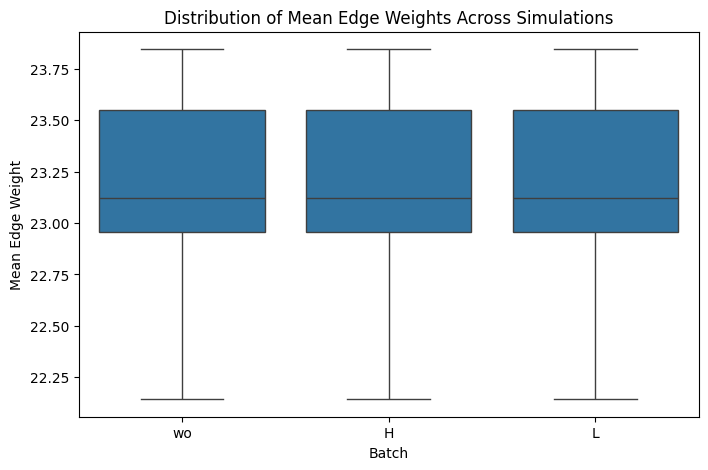

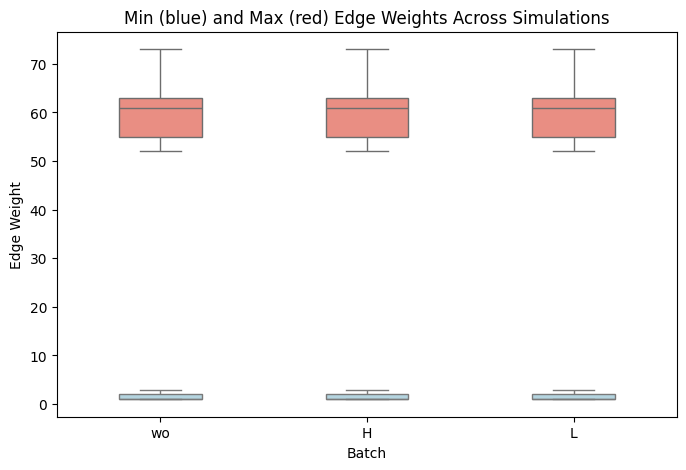

In [196]:
# Collect all edge weight summaries into one DataFrame with a batch label
all_summaries = []

for label, results in analysis_results.items():
    df = results['edge_weight_summary'].copy()
    df['batch'] = label
    all_summaries.append(df)

summary_df = pd.concat(all_summaries, ignore_index=True)

# Plot boxplots of mean edge weights per batch
plt.figure(figsize=(8,5))
sns.boxplot(x='batch', y='mean_weight', data=summary_df)
plt.title("Distribution of Mean Edge Weights Across Simulations")
plt.ylabel("Mean Edge Weight")
plt.xlabel("Batch")
plt.show()

# Optional: also plot min and max weights if you want full range comparison
plt.figure(figsize=(8,5))
sns.boxplot(x='batch', y='min_weight', data=summary_df, color='lightblue', width=0.4)
sns.boxplot(x='batch', y='max_weight', data=summary_df, color='salmon', width=0.4)
plt.title("Min (blue) and Max (red) Edge Weights Across Simulations")
plt.ylabel("Edge Weight")
plt.xlabel("Batch")
plt.show()


# Old Analysis
Can ignore , but I left it in case of any curiousity

In [197]:
# G: interaction frequency between agents
rows = []
for idx, G in enumerate(networkG):
    row = {"Simulation": idx}

    # Basic properties
    row["Node Count"] = G.number_of_nodes()
    row["Edge Count"] = G.number_of_edges()
    row["Density"] = nx.density(G)

    # Components
    row["Connected Components"] = nx.number_connected_components(G)

    # Clustering
    row["Transitivity"] = nx.transitivity(G)
    row["Avg Clustering"] = nx.average_clustering(G) # average clustering coefficient

    # Connectivity
    row['Node Connectivity'] = nx.node_connectivity(G)
    row['Average Node Connectivity'] = nx.average_node_connectivity(G)
    row['Edge Connectivity'] = nx.edge_connectivity(G)
    row["Avg Shortest Path"] = nx.average_shortest_path_length(G)
    row["Diameter"] = nx.diameter(G)
    row["Radius"] = nx.radius(G)

    # Communities
    try:
        communities_mod = list(nx.community.greedy_modularity_communities(G))
        row["# Modularity Communities"] = len(communities_mod)
    except:
        row["# Modularity Communities"] = None

    try:
        communities_label = list(nx.community.label_propagation_communities(G))
        row["# Label Communities"] = len(communities_label)
    except:
        row["# Label Communities"] = None

    rows.append(row)

# Create DataFrame
df = pd.DataFrame(rows)

# Display it nicely
print(df.to_string(index=False))

 Simulation  Node Count  Edge Count  Density  Connected Components  Transitivity  Avg Clustering  Node Connectivity  Average Node Connectivity  Edge Connectivity  Avg Shortest Path  Diameter  Radius  # Modularity Communities  # Label Communities
          0          14          91      1.0                     1           1.0             1.0                 13                       13.0                 13                1.0         1       1                         1                    1
          1          14          91      1.0                     1           1.0             1.0                 13                       13.0                 13                1.0         1       1                         1                    1
          2          14          91      1.0                     1           1.0             1.0                 13                       13.0                 13                1.0         1       1                         1                    1
          3     

In [198]:
# Per node measures:
node_rows = []
for idx, G in enumerate(networkG):
    try:
        deg_centrality = nx.degree_centrality(G)
        btw_centrality = nx.betweenness_centrality(G)
        cls_centrality = nx.closeness_centrality(G)
        eig_centrality = nx.eigenvector_centrality(G)
        triangles = nx.triangles(G)
        clustering = nx.clustering(G)
    except:
        continue  # if any centrality fails (e.g., eigenvector on disconnected graph)

    for node in G.nodes():
        row = {
            "Simulation": idx,
            "Node": node,
            "Degree Centrality": deg_centrality.get(node),
            "Betweenness Centrality": btw_centrality.get(node),
            "Closeness Centrality": cls_centrality.get(node),
            "Eigenvector Centrality": eig_centrality.get(node),
            "Triangle Count": triangles.get(node),
            "Clustering Coefficient": clustering.get(node),
        }
        node_rows.append(row)

# Create DataFrame
node_df = pd.DataFrame(node_rows)

# Display the full node-level table
print(node_df.to_string(index=False))

 Simulation  Node  Degree Centrality  Betweenness Centrality  Closeness Centrality  Eigenvector Centrality  Triangle Count  Clustering Coefficient
          0     0                1.0                     0.0                   1.0                0.267261              78                     1.0
          0     1                1.0                     0.0                   1.0                0.267261              78                     1.0
          0     2                1.0                     0.0                   1.0                0.267261              78                     1.0
          0     3                1.0                     0.0                   1.0                0.267261              78                     1.0
          0     4                1.0                     0.0                   1.0                0.267261              78                     1.0
          0     5                1.0                     0.0                   1.0                0.267261            

In [199]:
# DG: how much the agents influenced each other -- the cumaltive change in emotion valence, not the net-change in their emotion valence
rows = []
for idx, DG in enumerate(networkDG):
    row = {"Simulation": idx}

    # Basic properties
    row["Node Count"] = DG.number_of_nodes()
    row["Edge Count"] = DG.number_of_edges()
    row["Density"] = nx.density(DG)

    # Components
    row["Weakly Connected Components"] = nx.number_weakly_connected_components(DG)
    row["Strongly Connected Components"] = nx.number_strongly_connected_components(DG)

    # Clustering
    row["Transitivity"] = nx.transitivity(DG)
    row['Node Clustering'] = nx.clustering(DG)  # node clustering coefficient
    row["Avg Clustering"] = nx.average_clustering(DG) # average clustering coefficient

    # Connectivity
    row['Edge Connectivity'] = nx.edge_connectivity(DG)
    row["Avg Shortest Path"] = nx.average_shortest_path_length(DG)
    row["Diameter"] = nx.diameter(DG)
    row["Radius"] = nx.radius(DG)

    # Communities
    try:
        communities_mod = list(nx.community.greedy_modularity_communities(DG))
        row["# Modularity Communities"] = len(communities_mod)
    except:
        row["# Modularity Communities"] = None

    try:
        communities_label = list(nx.community.greedy_modularity_communities(DG))
        row["# Label Communities"] = len(communities_label)
    except:
        row["# Label Communities"] = None

    rows.append(row)

# Create DataFrame
df = pd.DataFrame(rows)

# Display it nicely
print(df.to_string(index=False))

 Simulation  Node Count  Edge Count  Density  Weakly Connected Components  Strongly Connected Components  Transitivity                                                                                                      Node Clustering  Avg Clustering  Edge Connectivity  Avg Shortest Path  Diameter  Radius  # Modularity Communities  # Label Communities
          0          14         182      1.0                            1                              1           1.0 {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0, 12: 1.0, 13: 1.0}             1.0                 13                1.0         1       1                         1                    1
          1          14         182      1.0                            1                              1           1.0 {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0, 12: 1.0, 13: 1.0}             1.0                 13                1.0 

In [200]:
# Per node measures:
node_rows = []
for idx, DG in enumerate(networkDG):
    try:
        deg_centrality = nx.degree_centrality(DG)
        btw_centrality = nx.betweenness_centrality(DG)
        cls_centrality = nx.closeness_centrality(DG)
        eig_centrality = nx.eigenvector_centrality(DG)
        clustering = nx.clustering(DG)
    except:
        continue  # if any centrality fails (e.g., eigenvector on disconnected graph)

    for node in DG.nodes():
        row = {
            "Simulation": idx,
            "Node": node,
            "Degree Centrality": deg_centrality.get(node),
            "Betweenness Centrality": btw_centrality.get(node),
            "Closeness Centrality": cls_centrality.get(node),
            "Eigenvector Centrality": eig_centrality.get(node),
            "Clustering Coefficient": clustering.get(node)
        }
        node_rows.append(row)

# Create DataFrame
node_df = pd.DataFrame(node_rows)

# Display the full node-level table
print(node_df.to_string(index=False))

 Simulation  Node  Degree Centrality  Betweenness Centrality  Closeness Centrality  Eigenvector Centrality  Clustering Coefficient
          0     0                2.0                     0.0                   1.0                0.267261                     1.0
          0     1                2.0                     0.0                   1.0                0.267261                     1.0
          0     2                2.0                     0.0                   1.0                0.267261                     1.0
          0     3                2.0                     0.0                   1.0                0.267261                     1.0
          0     4                2.0                     0.0                   1.0                0.267261                     1.0
          0     5                2.0                     0.0                   1.0                0.267261                     1.0
          0     6                2.0                     0.0                   1.0 